# MRI Classification Using PyTorch

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.datasets import ImageFolder
import seaborn as sns
import shutil
import json
import gc

## Data Preparation
Load the dataset and split it into training and validation sets, starting with first fold generated by data_preparation.ipynb

In [2]:
with open('mean_std.json', 'r') as f:
    mean_std = json.load(f)

mean = mean_std['mean']
std = mean_std['std']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load data for fold 0
k_folds = 5
base_dir = 'dataset_kfold'
fold = 0
train_dir = os.path.join(base_dir, f'fold_{fold}', 'train')
val_dir = os.path.join(base_dir, f'fold_{fold}', 'val')
fold += 1

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

## Define the Model

In [3]:
# Define the ResNet model
class SimpleResNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleResNet, self).__init__()
        #self.model = models.resnet50(pretrained=True)
        self.model = models.resnet50()
        self.model.fc = nn.Sequential(
            #nn.Dropout(0.4),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleResNet(num_classes=num_classes).to(device)

/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [5]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        if batch_idx % 10 == 9:  # print every 10 batches
            print(f'Epoch {epoch}, Batch {batch_idx + 1}, Loss: {running_loss / 10:.4f}')
            running_loss = 0.0
    accuracy = 100. * correct / total
    return running_loss / len(train_loader), accuracy

# Define the validation function
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    val_loss /= len(val_loader)
    accuracy = 100. * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return val_loss, accuracy, all_preds, all_labels


## Start training the model

In [6]:
# Training and validation loop with early stopping
num_epochs = 10
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
all_preds = []
all_labels = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
    val_loss, val_acc, preds, labels = validate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    all_preds.extend(preds)
    all_labels.extend(labels)
    
    print(f'Epoch {epoch+1}/{num_epochs} - '
          f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f} - '
          f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}')
    
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model if necessary
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print('Early stopping!')
        break
    

Epoch 0, Batch 10, Loss: 1.0124
Validation Loss: 0.4404, Accuracy: 89.58%
Epoch 1/10 - Train loss: 0.0891, Train accuracy: 62.7604 - Val loss: 0.4404, Val accuracy: 89.5833
Epoch 1, Batch 10, Loss: 0.2968
Validation Loss: 0.3442, Accuracy: 87.50%
Epoch 2/10 - Train loss: 0.0280, Train accuracy: 92.4479 - Val loss: 0.3442, Val accuracy: 87.5000
Epoch 2, Batch 10, Loss: 0.0548
Validation Loss: 0.2357, Accuracy: 89.58%
Epoch 3/10 - Train loss: 0.0118, Train accuracy: 99.7396 - Val loss: 0.2357, Val accuracy: 89.5833
Epoch 3, Batch 10, Loss: 0.0210
Validation Loss: 0.1572, Accuracy: 93.75%
Epoch 4/10 - Train loss: 0.0024, Train accuracy: 100.0000 - Val loss: 0.1572, Val accuracy: 93.7500
Epoch 4, Batch 10, Loss: 0.0102
Validation Loss: 0.1447, Accuracy: 95.83%
Epoch 5/10 - Train loss: 0.0009, Train accuracy: 100.0000 - Val loss: 0.1447, Val accuracy: 95.8333
Epoch 5, Batch 10, Loss: 0.0071
Validation Loss: 0.1305, Accuracy: 94.79%
Epoch 6/10 - Train loss: 0.0006, Train accuracy: 100.0000 -

## Visualize

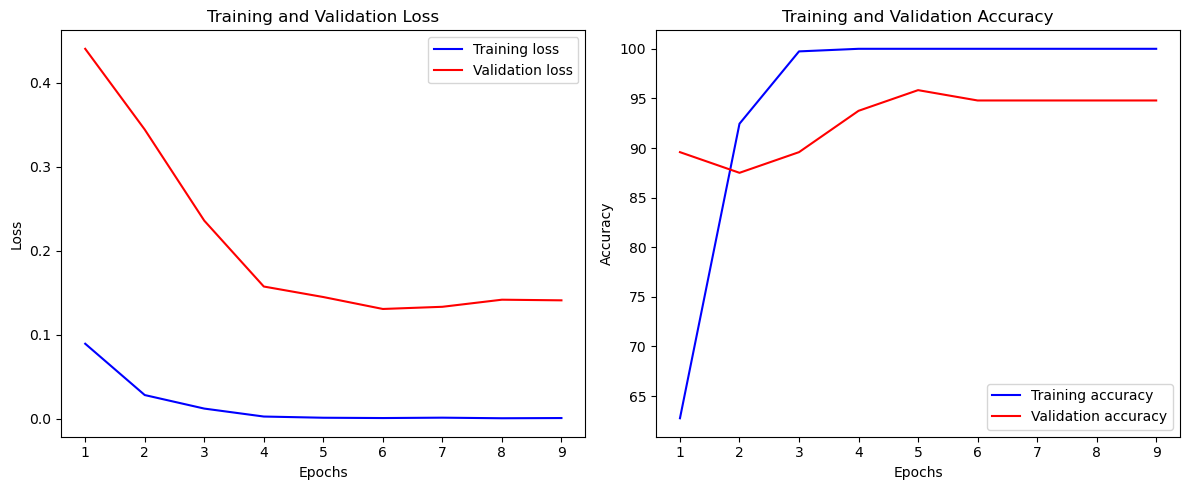

In [7]:
# Plotting the results
actual_epochs = range(1, epoch + 2)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(actual_epochs, train_losses, 'b', label='Training loss')
plt.plot(actual_epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(actual_epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(actual_epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


<Figure size 1000x700 with 0 Axes>

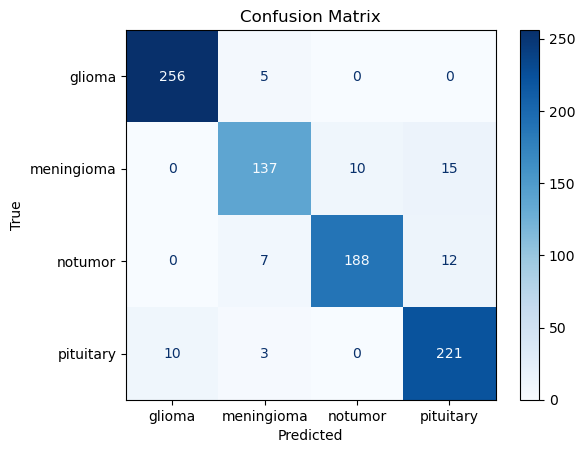

In [8]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=val_dataset.classes)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Remaining k-fold, train and visualize

In [14]:
fold_results = []

# Loop over each fold
for f in range(1, k_folds):
    print(f'Fold {f + 1}/{k_folds}')

    # Load data for fold
    train_dir = os.path.join(base_dir, f'fold_{f}', 'train')
    val_dir = os.path.join(base_dir, f'fold_{f}', 'val')

    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

    # Set device and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleResNet(num_classes=num_classes).to(device)

    # Optimizer and criterion
    # optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    # Early stopping parameters
    num_epochs = 10
    patience = 3
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    all_preds = []
    all_labels = []

    # Training loop with early stopping
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
        val_loss, val_acc, preds, labels = validate(model, device, val_loader, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        all_preds.extend(preds)
        all_labels.extend(labels)

        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f} - '
              f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model if necessary
            # torch.save(model.state_dict(), f'best_model_fold_{f}.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping!')
            break

    # Compute the confusion matrix
    # conf_matrix = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

    # # Plot the confusion matrix
    # plt.figure(figsize=(10, 7))
    # disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=val_dataset.classes)
    # disp.plot(cmap='Blues')
    # plt.title(f'Confusion Matrix for Fold {f + 1}')
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.show()

    # Free CUDA memory after training
    torch.cuda.empty_cache()
    gc.collect()

    # Store fold results
    fold_results.append({
        'fold': f,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss,
        'conf_matrix': conf_matrix
    })

Fold 2/5


/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xj/miniconda3/envs/pytorchenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Batch 10, Loss: 0.8804
Validation Loss: 0.7625, Accuracy: 66.67%
Epoch 1/10 - Train loss: 0.0835, Train accuracy: 68.7500 - Val loss: 0.7625, Val accuracy: 66.6667
Epoch 1, Batch 10, Loss: 0.1632
Validation Loss: 0.5122, Accuracy: 82.29%
Epoch 2/10 - Train loss: 0.0221, Train accuracy: 97.1354 - Val loss: 0.5122, Val accuracy: 82.2917
Epoch 2, Batch 10, Loss: 0.0536
Validation Loss: 0.5791, Accuracy: 80.21%
Epoch 3/10 - Train loss: 0.0096, Train accuracy: 98.9583 - Val loss: 0.5791, Val accuracy: 80.2083
Epoch 3, Batch 10, Loss: 0.0271
Validation Loss: 0.6195, Accuracy: 82.29%
Epoch 4/10 - Train loss: 0.0071, Train accuracy: 99.7396 - Val loss: 0.6195, Val accuracy: 82.2917
Epoch 4, Batch 10, Loss: 0.0089
Validation Loss: 0.6125, Accuracy: 83.33%
Epoch 5/10 - Train loss: 0.0009, Train accuracy: 100.0000 - Val loss: 0.6125, Val accuracy: 83.3333
Early stopping!
Fold 3/5
Epoch 0, Batch 10, Loss: 0.9509
Validation Loss: 0.6185, Accuracy: 79.17%
Epoch 1/10 - Train loss: 0.0892, Tr

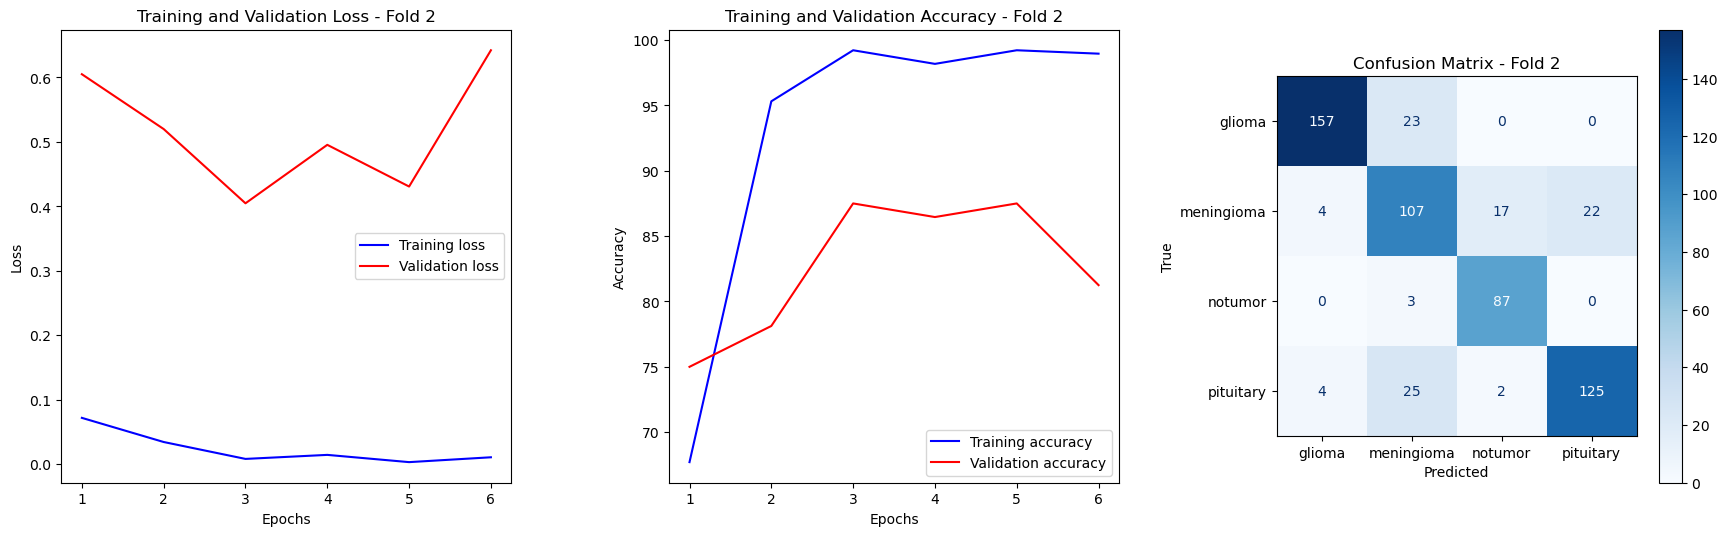

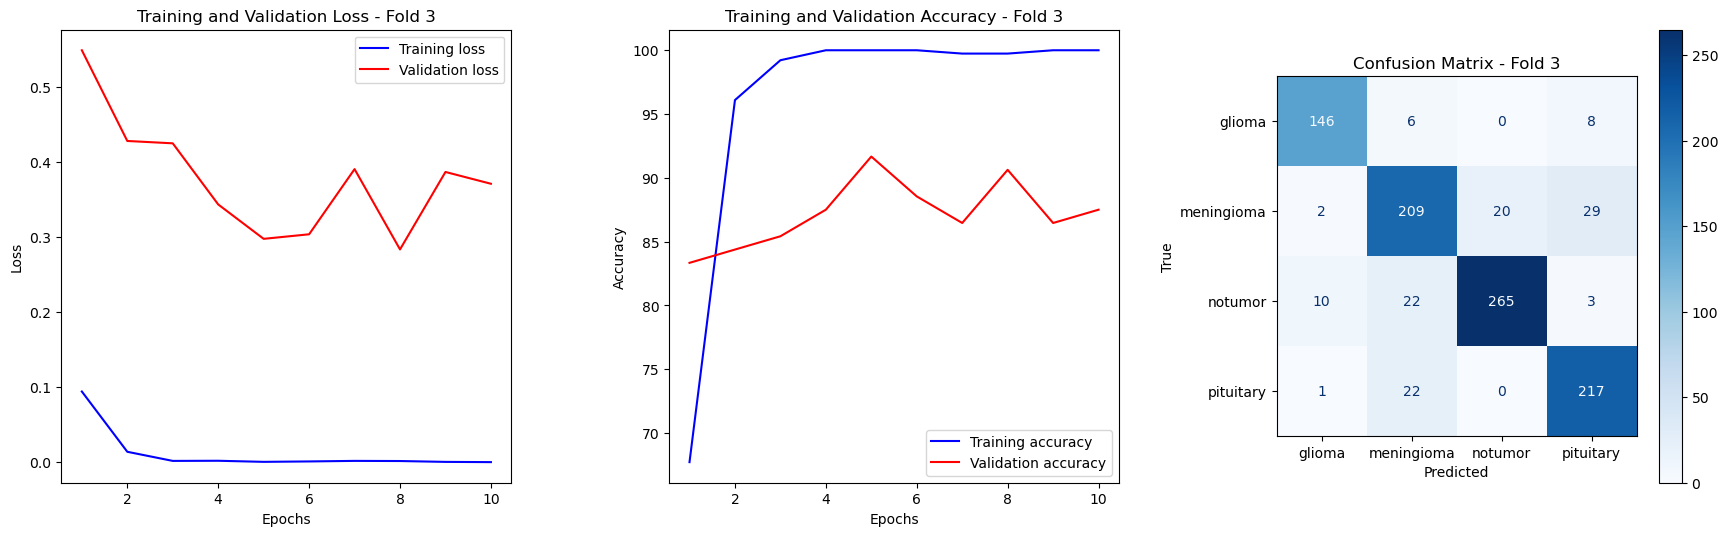

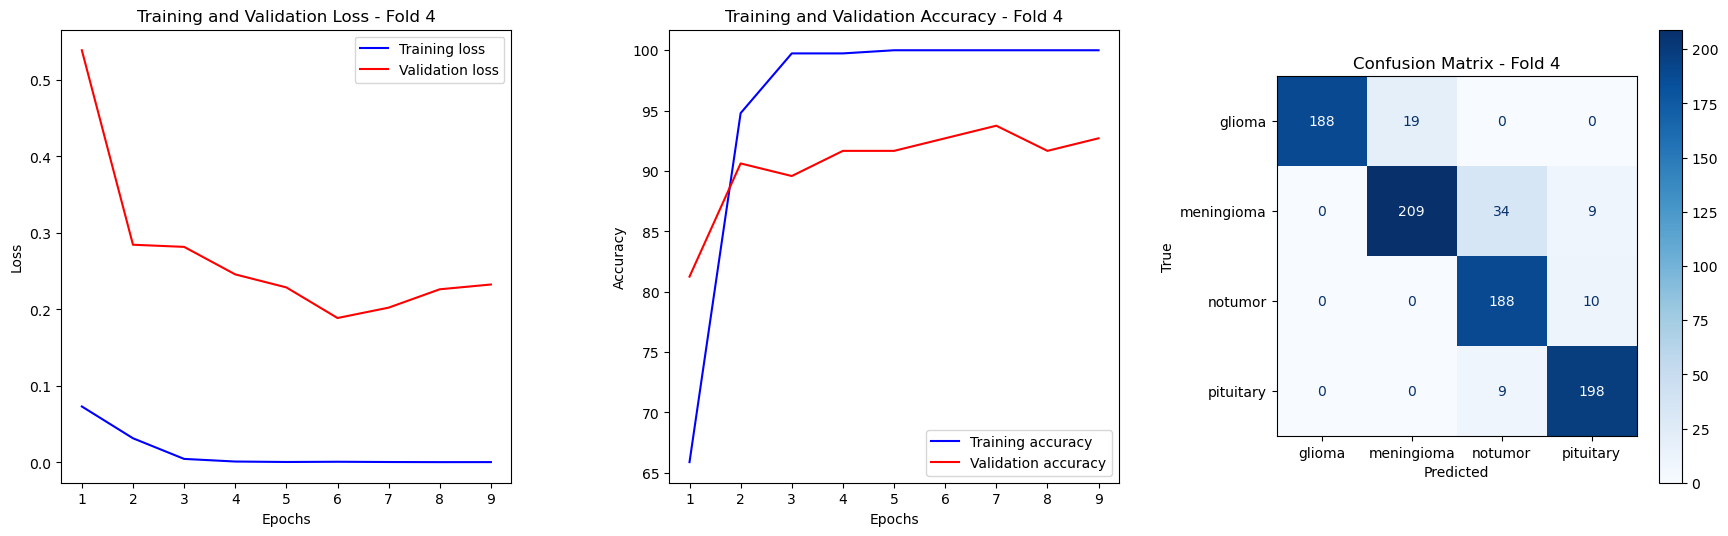

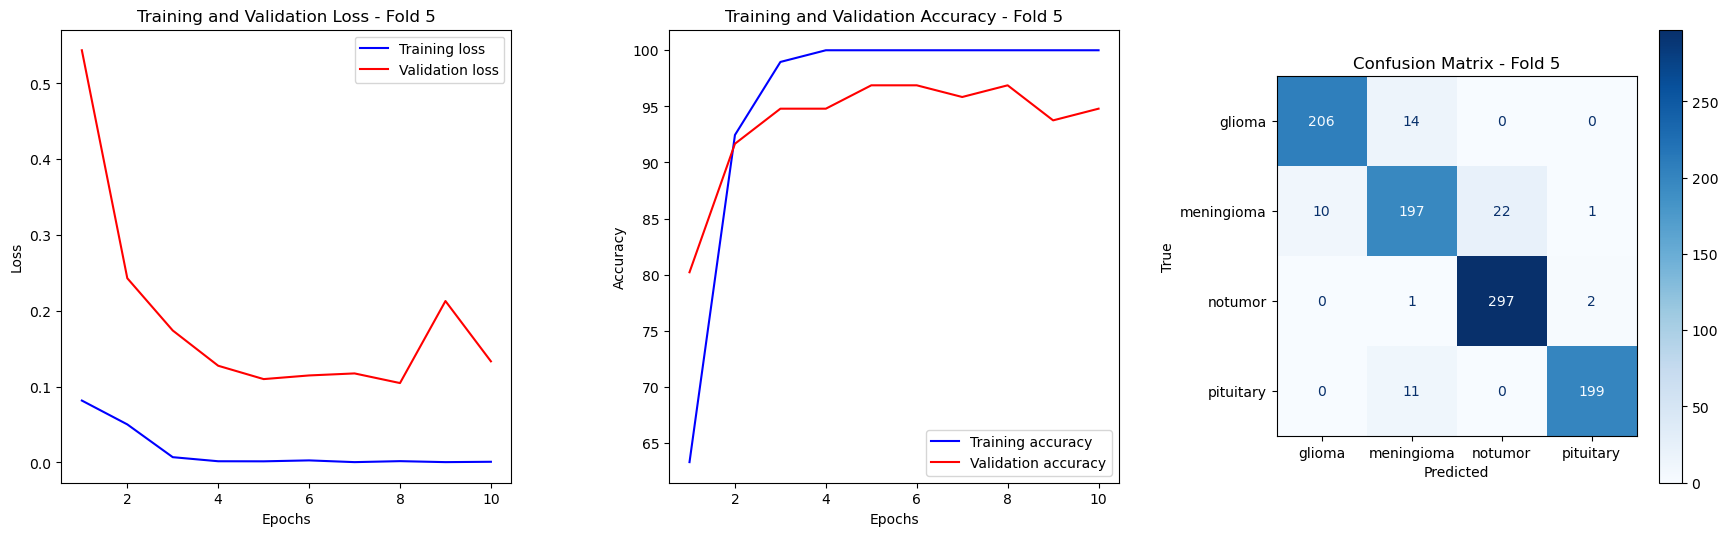

In [13]:
# Plotting results for each fold
for fold_result in fold_results:
    actual_epochs = range(1, len(fold_result['train_losses']) + 1)
    plt.figure(figsize=(18, 6))

    # Plot Training and Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(actual_epochs, fold_result['train_losses'], 'b', label='Training loss')
    plt.plot(actual_epochs, fold_result['val_losses'], 'r', label='Validation loss')
    plt.title(f'Training and Validation Loss - Fold {fold_result["fold"] + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(actual_epochs, fold_result['train_accuracies'], 'b', label='Training accuracy')
    plt.plot(actual_epochs, fold_result['val_accuracies'], 'r', label='Validation accuracy')
    plt.title(f'Training and Validation Accuracy - Fold {fold_result["fold"] + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Confusion Matrix
    plt.subplot(1, 3, 3)
    conf_matrix = fold_result['conf_matrix']
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=val_dataset.classes)
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title(f'Confusion Matrix - Fold {fold_result["fold"] + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout(pad=3.0)
    plt.show()

# Calculate mean and variance of validation accuracies across all folds
val_accuracies_all_folds = [result['val_accuracies'][-1] for result in fold_results]  # Take the last epoch's accuracy from each fold
mean_accuracy = np.mean(val_accuracies_all_folds)
variance_accuracy = np.var(val_accuracies_all_folds)

# Display the mean and variance
print(f'Mean Validation Accuracy across all folds: {mean_accuracy:.2f}%')
print(f'Variance of Validation Accuracy across all folds: {variance_accuracy:.2f}%')


## Test

In [ ]:
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # Pause a bit so that plots are updated

# # Ensure Matplotlib inline backend is set
# %matplotlib inline

# # Get one batch of validation data
# inputs, classes = next(iter(val_loader))

# inputs = inputs.to(device)
# classes = classes.to(device)
# # Load the entire model

# #Instantiate the model architecture
# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# # Replace the final fully connected layer with the number of classes in your dataset
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, num_classes)

# # Load the model state dictionary
# model.load_state_dict(torch.load('models/transfer_resnet_best.pth'))

# model = model.to(device)
# # Move the model to the appropriate device
# # Make predictions
# model.eval()
# with torch.no_grad():
#     outputs = model(inputs)
#     _, preds = torch.max(outputs, 1)

# # Move the inputs and classes to CPU for visualization
# inputs = inputs.cpu()
# classes = classes.cpu()
# preds = preds.cpu()

# # Class names
# class_names = train_dataset.classes

# # Randomly choose one data point to visualize
# index = random.randint(0, len(inputs) - 1)  # Select a random index from the batch
# input_image = inputs[index]
# predicted_label = class_names[preds[index]]
# actual_label = class_names[classes[index]]

# # Plot the image along with its predicted and actual labels
# plt.figure(figsize=(5, 5))
# imshow(input_image, title=f"Pred: {predicted_label}\nActual: {actual_label}")
# plt.show()
